# PA2 Problem 3

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys
sys.path.append(os.path.abspath('/content/drive/MyDrive/2_pose_estimation'))

from model import *
import torch
import numpy as np
import torchvision
import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
import math
import torch.nn as nn
import torch.optim as optim

from glob import glob
import pandas
import matplotlib.pyplot as plt

device = 'cuda:0'
num_joints = 21

In [3]:
class Dataset(Dataset):
    def __init__(self, method=None):
        self.root = '/content/drive/MyDrive/2_pose_estimation/dataset/'
        self.x_data = []
        self.y_data = []
        if method == 'train':
            self.root = self.root + 'train/'
            self.img_path = sorted(glob(self.root + 'rgb/*.jpg'))

        elif method == 'test':
            self.root = self.root + 'test/'
            self.img_path = sorted(glob(self.root + 'rgb/*.jpg'))

        for i in tqdm.tqdm(range(len(self.img_path))):
            img = cv2.imread(self.img_path[i], cv2.IMREAD_COLOR)
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            self.x_data.append(img)

            num = self.img_path[i].split('.')[0].split('/')[-1]
            img_pkl = self.root + 'meta/' + str(num) + '.pkl'
            pkl = pandas.read_pickle(img_pkl)
            coords_2d = pkl['coords_2d']
            self.y_data.append(coords_2d)

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        transform1 = torchvision.transforms.ToTensor()
        new_x_data = transform1(self.x_data[idx])

        return new_x_data, self.y_data[idx]

In [4]:
class Tester(object):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self._build_model()

        self.root = '/content/drive/MyDrive/2_pose_estimation/dataset/'

        # Load of pretrained_weight file
        weight_PATH = '/content/drive/MyDrive/2_pose_estimation/dataset/pretrained_weight.pth'
        self.poseNet.load_state_dict(torch.load(weight_PATH))

        print("Testing...")

    def _build_model(self):
        # 2d pose estimator
        poseNet = CPM2DPose()
        self.poseNet = poseNet.to(device)

        print('Finish build model.')

    def heatmap2skeleton(self, heatmapsPoseNet):
        skeletons = np.zeros((heatmapsPoseNet.shape[0], heatmapsPoseNet.shape[1], 2))
        for m in range(heatmapsPoseNet.shape[0]):
            for i in range(heatmapsPoseNet.shape[1]):
                u, v = np.unravel_index(np.argmax(heatmapsPoseNet[m][i]), (32, 32))
                skeletons[m, i, 0] = u * 8
                skeletons[m, i, 1] = v * 8
        return skeletons

    @staticmethod
    def plot_hand(coords_hw, axis, color_fixed=None, linewidth='1'):
        colors = np.array([[0., 0., 1.],
                           [0., 0., 1.],
                           [0., 0., 1.],
                           [0., 0., 1.],
                           [1., 0., 1.],
                           [1., 0., 1.],
                           [1., 0., 1.],
                           [1., 0., 1.],
                           [1., 0., 0.],
                           [1., 0., 0.],
                           [1., 0., 0.],
                           [1., 0., 0.],
                           [0., 1., 0.],
                           [0., 1., 0.],
                           [0., 1., 0.],
                           [0., 1., 0.],
                           [1., 0.5, 0.],
                           [1., 0.5, 0.],
                           [1., 0.5, 0.],
                           [1., 0.5, 0.]])
        bones = [((1, 0), colors[0, :]),
                 ((2, 1), colors[1, :]),
                 ((3, 2), colors[2, :]),
                 ((4, 3), colors[3, :]),
                 ((0, 5), colors[4, :]),
                 ((5, 6), colors[5, :]),
                 ((6, 7), colors[6, :]),
                 ((7, 8), colors[7, :]),
                 ((0, 9), colors[8, :]),
                 ((9, 10), colors[9, :]),
                 ((10, 11), colors[10, :]),
                 ((11, 12), colors[11, :]),
                 ((0, 13), colors[12, :]),
                 ((13, 14), colors[13, :]),
                 ((14, 15), colors[14, :]),
                 ((15, 16), colors[15, :]),
                 ((0, 17), colors[16, :]),
                 ((17, 18), colors[17, :]),
                 ((18, 19), colors[18, :]),
                 ((19, 20), colors[19, :])]
        for connection, color in bones:
            coord1 = coords_hw[connection[0], :]
            coord2 = coords_hw[connection[1], :]
            coords = np.stack([coord1, coord2])
            if color_fixed is None:
                axis.plot(coords[:, 1], coords[:, 0], color=color, linewidth=linewidth)
            else:
                axis.plot(coords[:, 1], coords[:, 0], color_fixed, linewidth=linewidth)

    # test '106.png' image
    def test106(self, epochs, batch_size, learning_rate, finetuned=False):
        print("Finetuned" if finetuned else "Not finetuned")

        # load weight file
        if finetuned:
            weight_PATH = "/content/drive/MyDrive/2_pose_estimation/dataset/train/finetuned_{epochs}_{batch_size}_{learning_rate}.pth".format(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate)
            
        else:
            weight_PATH = '/content/drive/MyDrive/2_pose_estimation/dataset/train/pretrained_weight.pth'

        self.poseNet.load_state_dict(torch.load(weight_PATH))
        path = self.root + 'test/rgb/106.jpg'
        pkl_path = self.root + 'test/meta/106.pkl'
        print(path)
        print(pkl_path)

        img = cv2.imread(path, cv2.IMREAD_COLOR)
        b, g, r = cv2.split(img)
        img = cv2.merge([r, g, b])
        transform1 = torchvision.transforms.ToTensor()
        x_data = transform1(img)
        pkl = pandas.read_pickle(pkl_path)
        y_test = pkl['coords_2d']

        self.poseNet.eval()

        print("Testing 106.jpg heatmap")

        print(x_data.size())

        heatmapsPoseNet = self.poseNet(x_data.unsqueeze(0).cuda()).cpu().detach().numpy()
        heatmap = np.transpose(heatmapsPoseNet[0], (1, 2, 0))

        save_path = "/content/drive/MyDrive/2_pose_estimation/dataset/"
        plt.rcParams['figure.figsize'] = [12, 5]
        for i in range(num_joints):
            ax = plt.subplot(3, 7, i + 1)
            ax.imshow(heatmap[:, :, i])
        plt.savefig(save_path + "heatmap_{epochs}_{batch_size}_{learning_rate}.png".format(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate))
        plt.show()

        print("Testing 106.jpg heatmap")

        ax = plt.subplot(1, 1, 1)
        ax.imshow(img)
        pred = self.heatmap2skeleton(heatmapsPoseNet)[0]
        self.plot_hand(pred, ax)
        error = self.calc_error(y_test, pred)
        print(f"Error is {error}")
        plt.savefig(save_path + "result_{epochs}_{batch_size}_{learning_rate}.png".format(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate))
        plt.show()

    # test all images
    def test(self, epochs, batch_size, learning_rate, finetuned=False):
        print("Finetuned" if finetuned else "Not finetuned")

        # load weight file
        if finetuned:
            weight_PATH = "/content/drive/MyDrive/2_pose_estimation/dataset/train/finetuned_{epochs}_{batch_size}_{learning_rate}.pth".format(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate)
            
        else:
            weight_PATH = '/content/drive/MyDrive/2_pose_estimation/dataset/train/pretrained_weight.pth'

        self.poseNet.load_state_dict(torch.load(weight_PATH))

        totalError = 0
        for i in range(500):
            img_path = self.root + 'test/rgb/%d.jpg' % (i)
            pkl_path = self.root + 'test/meta/%d.pkl' % (i)
            print(img_path)

            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            transform1 = torchvision.transforms.ToTensor()
            x_data = transform1(img)
            pkl = pandas.read_pickle(pkl_path)
            y_test = pkl['coords_2d']

            self.poseNet.eval()

            heatmapsPoseNet = self.poseNet(x_data.unsqueeze(0).cuda()).cpu().detach().numpy()
            heatmap = np.transpose(heatmapsPoseNet[0], (1, 2, 0))

            pred = self.heatmap2skeleton(heatmapsPoseNet)[0]
            error = self.calc_error(y_test, pred)
            print(f"Testing {i}-th image's error is {error}")
            totalError += error

        print(f"Total Error is {totalError/500}")

    def calc_error(self, gt, pred):
        k = 21 # num of keypoints
        err = 0
        for i in range(k):
            err += math.sqrt(math.pow((gt[i][0] - pred[i][0]),2) + math.pow((gt[i][1] - pred[i][1]),2)) # calculate Loss

        err = err/k # Loss average of keypoints
        return err

In [5]:
class Trainer(object):
    def __init__(self, epochs, batch_size, lr):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = lr
        self._build_model()

        self.cost = nn.MSELoss()
        self.optimizer = optim.Adam(self.poseNet.parameters(), lr=self.learning_rate)

        dataset = Dataset(method='train')
        self.root = dataset.root
        self.dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        # Load of pretrained_weight file
        weight_PATH = '/content/drive/MyDrive/2_pose_estimation/dataset/pretrained_weight.pth'
        self.poseNet.load_state_dict(torch.load(weight_PATH))

    def _build_model(self):
        # 2d pose estimator
        poseNet = CPM2DPose()
        self.poseNet = poseNet.to(device)
        self.poseNet.train()

    def skeleton2heatmap(self, _heatmap, keypoint_targets):
        heatmap_gt = torch.zeros_like(_heatmap, device=_heatmap.device)

        keypoint_targets = (((keypoint_targets)) // 8)
        for i in range(keypoint_targets.shape[0]):
            for j in range(21):
                x = int(keypoint_targets[i, j, 0])
                y = int(keypoint_targets[i, j, 1])
                heatmap_gt[i, j, x, y] = 1

        heatmap_gt = heatmap_gt.detach().cpu().numpy()
        for i in range(keypoint_targets.shape[0]):
            for j in range(21):
                heatmap_gt[i, j, :, :] = cv2.GaussianBlur(heatmap_gt[i, j, :, :], ksize=(3, 3), sigmaX=2,
                                                          sigmaY=2) * 9 / 1.1772
        heatmap_gt = torch.FloatTensor(heatmap_gt).to(device)
        return heatmap_gt


    def heatmap2skeleton(self, heatmapsPoseNet):
        skeletons = np.zeros((heatmapsPoseNet.shape[0], heatmapsPoseNet.shape[1], 2))
        for m in range(heatmapsPoseNet.shape[0]):
            for i in range(heatmapsPoseNet.shape[1]):
                u, v = np.unravel_index(np.argmax(heatmapsPoseNet[m][i]), (32, 32))
                skeletons[m, i, 0] = u * 8
                skeletons[m, i, 1] = v * 8
        return skeletons

    # Prob 2
    def train(self):
        date = '202211'
        for epoch in tqdm.tqdm(range(self.epochs + 1)):
            totalLoss = 0
            if epoch % 2 == 0:
                torch.save(self.poseNet.state_dict(), self.root + "_".join(['model_', str(epoch), '.pth']))

            for batch_idx, samples in enumerate(self.dataloader):
                ##--------------------------
                # Implement your code here
                x_train, y_train = samples
                
                self.poseNet.eval()

                heatmapsPoseNet = self.poseNet(x_train.cuda()) # pred value
                loss = self.cost(heatmapsPoseNet, self.skeleton2heatmap(heatmapsPoseNet, y_train)) # calculate loss

                # leaning
                self.optimizer.zero_grad()
                loss.backward() 
                self.optimizer.step() 
                totalLoss += loss.item()

                print(f"Epoch {epoch}/{self.epochs}, Batch {batch_idx} loss is {loss.item()} \n")
                ##--------------------------

                ## Write train result
                if batch_idx % 20 == 0: # 21개의 keypoint 
                    with open('train_result_' + date + '.txt', 'a') as f:
                        f.write('Epoch {:4d}/{} Batch {}/{}\n'.format(
                            epoch, self.epochs, batch_idx, len(self.dataloader)
                        ))
                    print('Epoch {:4d}/{} Batch {}/{}'.format(
                        epoch, self.epochs, batch_idx, len(self.dataloader)
                    ))

            print('Loss is {}'.format(
                totalLoss/len(self.dataloader)
            ))

        # save trained weight
        train_path = self.root + "finetuned_{}_{}_{}.pth".format(self.epochs, self.batch_size, self.learning_rate)
        torch.save(self.poseNet.state_dict(), train_path)
        print('Finish training.')

Finish build model.
Testing...
Prob 3 - 1)
Finetuned
/content/drive/MyDrive/2_pose_estimation/dataset/test/rgb/106.jpg
/content/drive/MyDrive/2_pose_estimation/dataset/test/meta/106.pkl
Testing 106.jpg heatmap
torch.Size([3, 256, 256])


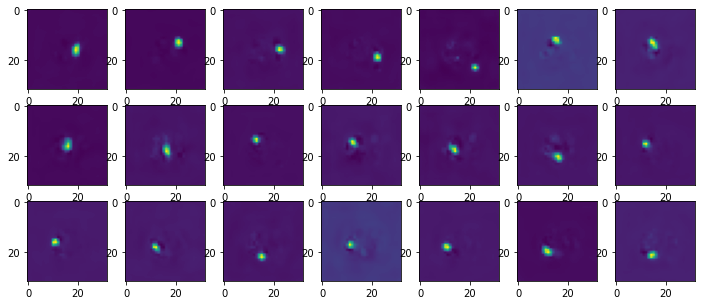

Testing 106.jpg heatmap
Error is 10.020755988449496


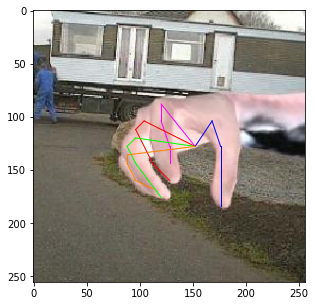

Prob 3 - 2)
Finetuned
/content/drive/MyDrive/2_pose_estimation/dataset/test/rgb/0.jpg
Testing 0-th image's error is 14.57666802079228
/content/drive/MyDrive/2_pose_estimation/dataset/test/rgb/1.jpg
Testing 1-th image's error is 8.283794718840314
/content/drive/MyDrive/2_pose_estimation/dataset/test/rgb/2.jpg
Testing 2-th image's error is 8.285075986790012
/content/drive/MyDrive/2_pose_estimation/dataset/test/rgb/3.jpg
Testing 3-th image's error is 49.65380247414166
/content/drive/MyDrive/2_pose_estimation/dataset/test/rgb/4.jpg
Testing 4-th image's error is 17.10651721834851
/content/drive/MyDrive/2_pose_estimation/dataset/test/rgb/5.jpg
Testing 5-th image's error is 9.760886415444515
/content/drive/MyDrive/2_pose_estimation/dataset/test/rgb/6.jpg
Testing 6-th image's error is 7.501209210835403
/content/drive/MyDrive/2_pose_estimation/dataset/test/rgb/7.jpg
Testing 7-th image's error is 10.998848529868871
/content/drive/MyDrive/2_pose_estimation/dataset/test/rgb/8.jpg
Testing 8-th imag

In [6]:
epochs = 60
batchSize = 20
learningRate = 2e-5

# Prob 2
# trainer = Trainer(epochs, batchSize, learningRate)
# trainer.train()

# Prob 3
tester = Tester(batchSize)
# Prob 3 - 1)
print("Prob 3 - 1)")
tester.test106(epochs, batchSize, learningRate, True)
# Prob 3 - 2)
print("Prob 3 - 2)")
tester.test(epochs, batchSize, learningRate, True)